<a href="https://colab.research.google.com/github/ziqlu0722/Machine-Learning/blob/master/RedSox_WinningPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 0. Import Needed Packages

In [0]:
# import necessary packages

import pandas as pd
import numpy as np
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
import random
%matplotlib inline

RANDOM_SEED = 13249845
random.seed(RANDOM_SEED)

/Users/lvziqing/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### 1. Get Data

In [0]:
# define a function to get data from www.baseball-reference.com"

def fetch_data(baseUrl,x):
    tempList = []
    for year in range(2010,2019):
        url = baseUrl.format(year)
        data = pd.read_html(url)[x]
        data['year'] = year
        tempList.append(data)
        print(len(tempList))
    result = pd.concat(tempList)
    return  result

In [0]:
# read html data and save as local csv

baseURL = 'https://www.baseball-reference.com/teams/tgl.cgi?team=BOS&t=b&year={}'
fetch_data(baseURL,0).to_csv('bos.csv',index=False)

1
2
3
4
5
6
7
8
9


#### 2. Clean Data

In [0]:
# read data from local data file

bos = pd.read_csv('bos.csv')

In [0]:
# remove the header of table for each month

bos.dropna(axis = 0, subset = ['Thr'], inplace = True)

In [0]:
# concate year and date

bos['time'] = bos.year.astype(str) + " " + bos.Date

In [0]:
# rough look at the data

bos.head()

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,PA,AB,R,H,...,BA,OBP,SLG,OPS,LOB,#,Thr,Opp. Starter (GmeSc),year,time
0,1,1.0,Apr 4,NaN,NYY,"W,9-7",39,34,9,12,...,.353,.410,.588,.998,6,9,L,C.Sabathia (38),2010,2010 Apr 4
1,2,2.0,Apr 6,NaN,NYY,"L,4-6",38,35,4,9,...,.304,.351,.507,.858,7,9,R,A.Burnett (43),2010,2010 Apr 6
2,3,3.0,Apr 7,NaN,NYY,"L,1-3",39,35,1,7,...,.269,.328,.423,.751,8,9,L,A.Pettitte (57),2010,2010 Apr 7
3,4,4.0,Apr 9,@,KCR,"L,3-4",38,33,3,9,...,.270,.333,.423,.757,8,10,R,K.Davies (50),2010,2010 Apr 9
4,5,5.0,Apr 10,@,KCR,"W,8-3",40,37,8,12,...,.282,.337,.494,.831,5,11,R,Z.Greinke (47),2010,2010 Apr 10


In [0]:
# list out all column names

bos.columns

Index(['Rk', 'Gtm', 'Date', 'Unnamed: 3', 'Opp', 'Rslt', 'PA', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE',
       'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'LOB', '#', 'Thr',
       'Opp. Starter (GmeSc)', 'year', 'time'],
      dtype='object')

In [0]:
# calculate 'Steal Base Percentage' with 'SB' and 'CS'

bos['SBP'] = bos['SB'].astype(int) / (bos['SB'].astype(int) + bos['CS'].astype(int))
bos['SBP'].fillna(0, inplace=True)
bos[['SBP', 'SB', 'CS']].head()

,SBP,SB,CS
0,0.0,0,0
1,1.0,2,0
2,0.0,0,0
3,0.0,0,1
4,1.0,1,0


In [0]:
# create HomeGame dummy data:
# 0 = home
# 1 = away

bos['ifHome'] = bos.iloc[:,3].apply(lambda x: 1 if x== '@' else 0)

In [0]:
# create WL, BostonScore, OpponentScore column

Rslt_split = bos.Rslt.str.replace(',', '-', regex = False).str.split('-', expand=True)
bos['WL'] = Rslt_split.iloc[:,0].map({'W': 1, 'L':0})
bos['BScore'] = Rslt_split.iloc[:,1]
bos['OScore'] = Rslt_split.iloc[:,2]

In [0]:
# filter out wanted sub data set

sub_bos = bos[['year','time','ifHome','Opp','WL','BScore','OScore','BA','SBP','OBP','SLG','OPS','LOB','GDP']]
sub_bos.columns = ['Year','Time','HomeGame','Opponent','WL','BScore','OScore','BA','SBP','OBP','SLG','OPS','LOB','GDP']

In [0]:
# convert data type of score to int, then caluculte score difference

sub_bos['OScore'].astype(int)
sub_bos['BScore'].astype(int)
sub_bos['Diff'] = sub_bos['BScore'].astype(int) - sub_bos['OScore'].astype(int)
sub_bos.head()

/Users/lvziqing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Year,Time,HomeGame,Opponent,WL,BScore,OScore,BA,SBP,OBP,SLG,OPS,LOB,GDP,Diff
0,2010,2010 Apr 4,0,NYY,1,9,7,.353,0.0,.410,.588,.998,6,0,2
1,2010,2010 Apr 6,0,NYY,0,4,6,.304,1.0,.351,.507,.858,7,1,-2
2,2010,2010 Apr 7,0,NYY,0,1,3,.269,0.0,.328,.423,.751,8,2,-2
3,2010,2010 Apr 9,1,KCR,0,3,4,.270,0.0,.333,.423,.757,8,1,-1
4,2010,2010 Apr 10,1,KCR,1,8,3,.282,1.0,.337,.494,.831,5,1,5


In [0]:
# save sub dataframe

sub_bos.to_csv('sub_bos.csv')

#### 3.Load Data

In [0]:
sub_bos = pd.read_csv('sub_bos.csv', index_col=0)
sub_bos.head()

,Year,Time,HomeGame,Opponent,WL,BScore,OScore,BA,SBP,OBP,SLG,OPS,LOB,GDP,Diff
0,2010,2010 Apr 4,0,NYY,1,9,7,0.353,0.0,0.410,0.588,0.998,6,0,2
1,2010,2010 Apr 6,0,NYY,0,4,6,0.304,1.0,0.351,0.507,0.858,7,1,-2
2,2010,2010 Apr 7,0,NYY,0,1,3,0.269,0.0,0.328,0.423,0.751,8,2,-2
3,2010,2010 Apr 9,1,KCR,0,3,4,0.270,0.0,0.333,0.423,0.757,8,1,-1
4,2010,2010 Apr 10,1,KCR,1,8,3,0.282,1.0,0.337,0.494,0.831,5,1,5


#### 4. Modeling

#### Model Set-up:

1. As data fact is binary - win or lose, we use Bernoulli distribution for the model

2. We assume a (lineaer) regression model for predicting the latent winning probability of the game. Potential influencing factors are __SBP, OBP, SLG, LOB, GDP, HomeGame, bias__

3. Since $p$ is constrained to be between zero and one, we transformed the linear function to numbers within 0~1 using invers logit b0 + b1*sbp + b2*obp + b3*slg + b4*lob + b5*gdp + b6*homeGame

    * $p_i = Inverslogit ( \beta_0 + \beta_1 * \text{SBP} + \beta_2 * \text{OBP}
\beta_3 * \text{SLG} + \beta_4 * \text{LOB} + \beta_5 * \text{GDP} + \beta_6 * \text{homeGame})$

    * $\beta_0$ is intercept here, $\beta_6$ is the coefficient evaluates how home game will affect the result


4. since we have 1500 games data, based on CLT, we choose Normal distibution for coefficients

In [0]:
# set variable we want to use in model, and covert data type of each value to target

sbp = sub_bos.SBP.values.astype(float)
obp = sub_bos.OBP.values.astype(float)
slg = sub_bos.SLG.values.astype(float)
lob = sub_bos.LOB.values.astype(float)
gdp = sub_bos.GDP.values.astype(float)
wl = sub_bos.WL.values.astype(int)
homeGame = sub_bos.HomeGame.values

In [0]:
# import necessary packages
from pymc3 import Bernoulli, Normal, sample, Deterministic, Model

In [0]:
# set parameters and deterministics of model

with pm.Model() as wl_model:
    b0 = Normal('b0', 0, sd=100)
    b1 = Normal('b1', 0, sd=100)
    b2 = Normal('b2', 0, sd=100)
    b3 = Normal('b3', 0, sd=100)
    b4 = Normal('b4', 0, sd=100)
    b5 = Normal('b5', 0, sd=100)
    b6 = Normal('b6', 0, sd=100)
    
    intercept_d = Deterministic('intercept_d', b0)
    sbp_d = Deterministic('sbp_d', b1)
    obp_d = Deterministic('obp_d', b2)
    slg_d = Deterministic('slg_d', b3)
    lob_d = Deterministic('lob_d', b4)
    gdp_d = Deterministic('gdp_d', b5)
    homeGame_d = Deterministic('homeGame_d', b6)

In [0]:
# set equition of p for Bernoulli, use invlogit to convert value falling into (0,1)

from pymc3.math import invlogit

with wl_model:        
    p = invlogit(b0 + b1*sbp + b2*obp + b3*slg + b4*lob + b5*gdp + b6*homeGame)

In [0]:
# set likehood as Bernoulli distribution, with calculated p

with wl_model:
    wl_like = Bernoulli('wl_like', p=p, observed=wl)

In [0]:
# draw samples with model

with wl_model:
    wl_sample = sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [homeGame_d, gdp_d, lob_d, slg_d, obp_d, sbp_d, intercept_d]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:35<00:00, 31.31draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c16a61a58>,
      dtype=object)

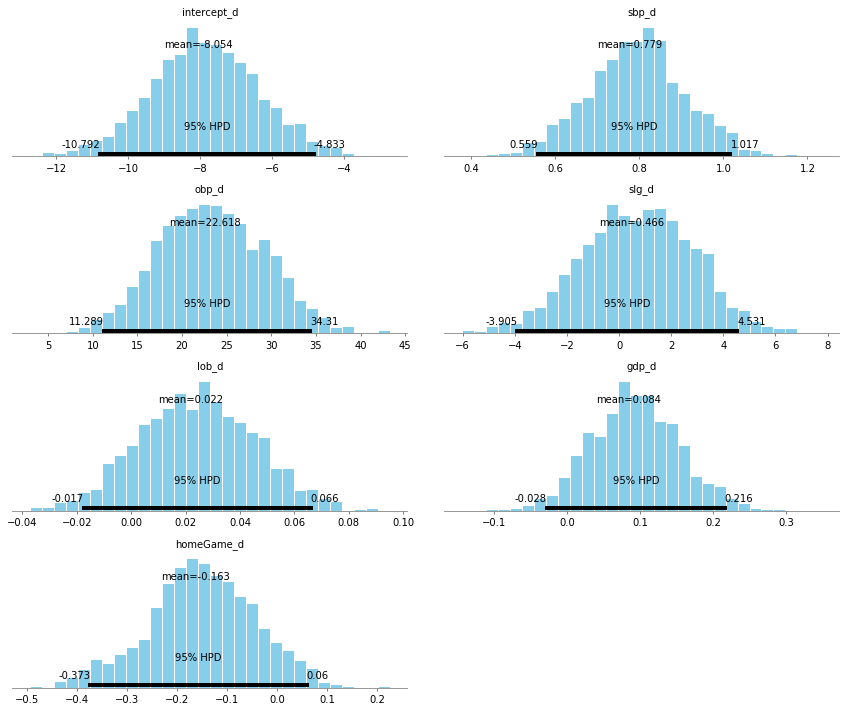

In [0]:
# plost posterior

from pymc3 import plot_posterior

plot_posterior(wl_sample[100:])

#### 5. Check Model Fit

In [0]:
# using ppc to check model fit

from pymc3 import sample_ppc

with wl_model:
    wl_ppc = sample_ppc(wl_sample)

100%|██████████| 1000/1000 [00:01<00:00, 845.12it/s]


In [0]:
# calculate actual winning percentage

win_p_actual = sub_bos['WL'].mean()
win_p_actual

0.5404663923182441

In [0]:
# calculate estimated winning percentage
# fit well, Give Me Five!

wl_ppc['wl_like'].mean()

0.5405507544581619

#### 6. Simulation

In [0]:
# import visualization packages for simulation

from IPython import display
from ipywidgets import interact, widgets

import random
random.seed(RANDOM_SEED)

In [0]:
# define a simulation function allowing adjustment of model variables

p_actual = pd.DataFrame(sub_bos.groupby(['Year'])['WL'].mean()).reset_index()
p_actual.columns = ['Year','Winning Probability']
p_actual_total = sub_bos.WL.mean()

def simulation(homeGame = 0,
               adjSBP = 0,
               adjOBP = 0, 
               adjSLG = 0,
               adjLOB = 0,
               adjGDP = 0):
    
    p_b = invlogit(   wl_sample['sbp_d'].mean() * sbp * (1 + adjSBP)
                    + wl_sample['obp_d'].mean() * obp * (1 + adjOBP)
                    + wl_sample['slg_d'].mean() * slg * (1 + adjSLG)
                    + wl_sample['lob_d'].mean() * lob * (1 + adjLOB)
                    + wl_sample['gdp_d'].mean() * gdp * (1 + adjGDP)
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
    p_predict = Bernoulli.dist(p = p_b).random().mean()
    
    p_actual.loc[9] = {'Year': 'Prediction', 'Winning Probability':p_predict}
    p_actual.plot.bar(  x = 'Year',
                        y = 'Winning Probability',
                        figsize=(8,6),    
                        color = 'blue')
    
    plt.ylabel('Winning Probability')
    plt.axis(ymin = 0, ymax=1)
    plt.axhline(p_actual_total, c='coral')

In [0]:
# plot each years' winning percentage, and the simulation of 2019
# with scale slider for key parameters to play with

interact(simulation, 
         homeGame = widgets.IntSlider(min=0, max=1, step=1),
         adjSBP = widgets.FloatSlider(min=-0.5, max=0.5, step=0.1),
         adjOBP = widgets.FloatSlider(min=-0.5, max=0.5, step=0.1),
         adjSLG = widgets.FloatSlider(min=-0.5, max=0.5, step=0.1),
         adjLOB = widgets.FloatSlider(min=-0.5, max=0.5, step=0.1),
         adjGDP = widgets.FloatSlider(min=-0.5, max=0.5, step=0.1))

interactive(children=(IntSlider(value=0, description='homeGame', max=1), FloatSlider(value=0.0, description='a…

<function __main__.simulation(homeGame=0, adjSBP=0, adjOBP=0, adjSLG=0, adjLOB=0, adjGDP=0)>

In [0]:
p_b = invlogit(   wl_sample['sbp_d'].mean() * sbp
                + wl_sample['obp_d'].mean() * obp
                + wl_sample['lob_d'].mean() * lob
                + wl_sample['slg_d'].mean() * slg
                + wl_sample['gdp_d'].mean() * gdp
                + wl_sample['homeGame_d'].mean() * homeGame
                + wl_sample['intercept_d'].mean())
    
p_predict_static = Bernoulli.dist(p = p_b).random().mean()

In [0]:
p_predict_static

0.5425240054869684

In [0]:
p_b_sbp = invlogit(   wl_sample['sbp_d'].mean() * sbp * (1 + 0.1)
                    + wl_sample['obp_d'].mean() * obp
                    + wl_sample['lob_d'].mean() * lob
                    + wl_sample['slg_d'].mean() * slg
                    + wl_sample['gdp_d'].mean() * gdp
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
p_predict_sbp = Bernoulli.dist(p = p_b_sbp).random().mean()

In [0]:
p_predict_sbp - p_predict_static

0.006172839506172867

In [0]:
p_b_obp = invlogit(   wl_sample['sbp_d'].mean() * sbp
                    + wl_sample['obp_d'].mean() * obp * (1 + 0.1)
                    + wl_sample['lob_d'].mean() * lob
                    + wl_sample['slg_d'].mean() * slg
                    + wl_sample['gdp_d'].mean() * gdp
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
p_predict_obp = Bernoulli.dist(p = p_b_obp).random().mean()

In [0]:
p_predict_obp - p_predict_static

0.15637860082304522

In [0]:
p_b_slg = invlogit(   wl_sample['sbp_d'].mean() * sbp
                    + wl_sample['obp_d'].mean() * obp
                    + wl_sample['lob_d'].mean() * lob
                    + wl_sample['slg_d'].mean() * slg * (1 + 0.1)
                    + wl_sample['gdp_d'].mean() * gdp
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
p_predict_slg = Bernoulli.dist(p = p_b_slg).random().mean()

In [0]:
p_predict_slg - p_predict_static

0.010288065843621408

In [0]:
p_b_lob = invlogit(   wl_sample['sbp_d'].mean() * sbp
                    + wl_sample['obp_d'].mean() * obp
                    + wl_sample['lob_d'].mean() * lob * (1 + 0.1)
                    + wl_sample['slg_d'].mean() * slg
                    + wl_sample['gdp_d'].mean() * gdp
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
p_predict_lob = Bernoulli.dist(p = p_b_lob).random().mean()

In [0]:
p_predict_lob - p_predict_static

0.004801097393689946

In [0]:
p_b_gdp = invlogit(   wl_sample['sbp_d'].mean() * sbp
                    + wl_sample['obp_d'].mean() * obp
                    + wl_sample['lob_d'].mean() * lob
                    + wl_sample['slg_d'].mean() * slg
                    + wl_sample['gdp_d'].mean() * gdp * (1 + 0.1)
                    + wl_sample['homeGame_d'].mean() * homeGame
                    + wl_sample['intercept_d'].mean())
    
p_predict_gdp = Bernoulli.dist(p = p_b_gdp).random().mean()

In [0]:
p_predict_gdp - p_predict_static

0.027434842249657088

In [0]:
p_b_homeGame = invlogit(   wl_sample['sbp_d'].mean() * sbp
                    + wl_sample['obp_d'].mean() * obp
                    + wl_sample['lob_d'].mean() * lob
                    + wl_sample['slg_d'].mean() * slg
                    + wl_sample['gdp_d'].mean() * gdp
                    + wl_sample['homeGame_d'].mean() * (homeGame - 5)
                    + wl_sample['intercept_d'].mean())
    
p_predict_homeGame = Bernoulli.dist(p = p_b_homeGame).random().mean()

In [0]:
p_predict_homeGame - p_predict_static

0.16186556927297668

#### 7. Conclusion

__Based on Bayesian Inference of Boston Red Sox Game to Game Log (2010~2018):__

1. __OBP__*(On Base Percentage)* and __HomeGame__ are two most effective stats for Boston Red Sox, to enhance winning probability in 2019
2. It's important for Red Sox to develop tactics to redeem **OBP** as **R**(run), cause **LOB**_(Left on Base)_ doesn't contribute to winning probablity a lot, yet **score** does  
3. Win as many as games in regular season to accumulate **Home Advantage** for series during play-off